### Imports

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import numpy as np

### Load pre-trained Faster R-CNN model

In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/Users/divay/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/divay/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### Define a function to preprocess the input image:

In [3]:
def preprocess(image_path):
    img = Image.open(image_path)
    transform = T.Compose([
        T.ToTensor(),
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    return img

#### Define a function to apply Non-Maximum Suppression to remove overlapping bounding boxes

In [4]:
def nms(boxes, scores, overlap_threshold=0.5):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        intersection = w * h
        union = areas[i] + areas[order[1:]] - intersection
        IoU = intersection / union

        inds = np.where(IoU <= overlap_threshold)[0]
        order = order[inds + 1]

    return keep

#### Define a function to perform object detection:

In [23]:
def detect_objects(image_path, conf_threshold=0.5, nms_threshold=0.5):
    img = preprocess(image_path)
    with torch.no_grad():
        predictions = model(img)[0]

    # Filter predictions based on the threshold
    keep_indices = predictions["scores"] > conf_threshold
    filtered_boxes = np.array(predictions["boxes"][keep_indices].tolist())
    filtered_scores = np.array(predictions["scores"][keep_indices].tolist())
    filtered_labels = np.array(predictions["labels"][keep_indices].tolist())

    # Apply NMS
    keep = nms(filtered_boxes, filtered_scores, overlap_threshold=nms_threshold)
    filtered_boxes = filtered_boxes[keep]
    filtered_scores = filtered_scores[keep]
    filtered_labels = filtered_labels
    filtered_labels = filtered_labels[keep]

    # Return the filtered predictions as a dictionary
    filtered_predictions = {
        'boxes': filtered_boxes,
        'scores': filtered_scores,
        'labels': filtered_labels
    }

    return filtered_predictions

#### Define a function to map class IDs to class names (COCO dataset):

In [11]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def id_to_class(class_id):
    return COCO_CLASSES[class_id]

#### Define a function to display the detected objects with their class names and bounding boxes

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_objects(image_path, predictions):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for boxes, labels in zip(predictions['boxes'], predictions['labels']):
        x1, y1, x2, y2 = boxes
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        class_name = id_to_class(labels)
        plt.text(x1, y1, class_name, fontsize=12, color='r', bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))

    plt.show()

#### Use the functions to detect objects in the images:

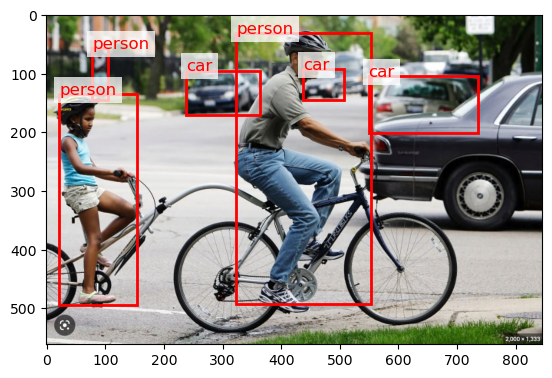

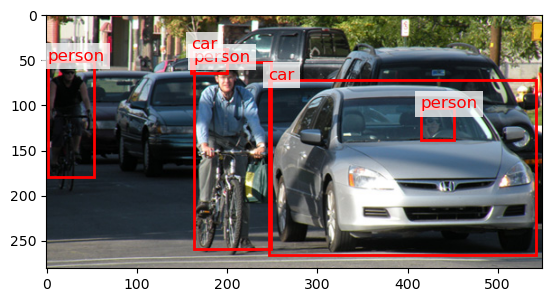

In [30]:
num_imgs = 2
for i in range(1, num_imgs+1):
    image_path = f'Input/{i}.jpg'
    predictions = detect_objects(image_path, conf_threshold=0.9, nms_threshold=0.1)
    display_objects(image_path, predictions)